# Problem

**State space.**
The states are encoded as integers
$$\mathcal{X} = {0,1,\dots,8} $$
corresponding to the grid in row-major order (top-left corner to bottom-right corner).
- State $8$ is the terminal goal state and is absorbing.
- State $5$ is the pit state and is absorbing.
- State $4$ is a wall.


**Action space.**
Actions are represented as integers

$$ \mathcal{A} = {0,1,2,3} $$

where $0 =$ Up, $1 =$ Down, $2 =$ Left, $3 =$ Right.

**Transition dynamics.**
Transitions are deterministic. For any state $x$ and action $a$, the state index is first mapped to its grid coordinates $(r,c)$, the action moves the agent one step (unless this would leave the grid), and the result is mapped back to a state index. The goal state $8$ always transitions to itself.
The transition matrix $P$ has shape $(|\mathcal{X}||\mathcal{A}|) \times |\mathcal{X}| = 36 \times 9$, where each row corresponds to a pair $(x,a)$ and contains a one-hot vector indicating the unique next state:

$$P[(x,a),x'] = 1 \quad \text{iff } x' = \text{next\_state}(x,a)$$

and $0$ otherwise.

**Reward model.**
- $r(x,a) = 1$ if x is a goal state.
- $r(x,a) = -5$ if x is the pit state.
- $r(x,a) = -0.1$ otherwise.

**Initial state.**
The initial state is fixed as $x_0 = 0$.

In [68]:
%load_ext autoreload
%autoreload 2

import os
import numpy as np
import pandas as pd
import sys
from pathlib import Path

PROJECT_ROOT = Path(os.getcwd()).resolve().parents[0]
# Add project root to the Python path
sys.path.append(str(PROJECT_ROOT))
# Define dataset path
DATASET_PATH = PROJECT_ROOT / "datasets" / "3grid_wall.csv"

from fogas import FOGASSolverVectorized, FOGASOracleSolverVectorized, FOGASHyperOptimizer, FOGASEvaluator, PolicySolver, EnvDataCollector

seed = 42

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Tabular Features

## Definition

### Description

**Feature Map**

We use a tabular one-hot feature representation over state–action pairs.
Each feature corresponds to a unique \((x,a)\) combination.

The feature map is defined as:
$$
\phi(x,a) \in \mathbb{R}^{36}
$$
with the ordering
$$
(x,a) \;\longrightarrow\; e_{\,x \cdot |\mathcal{A}| + a}
\quad |\mathcal{A}| = 4
$$

**Reward Weights**

The reward function is linear in the features:
$$
r(x,a) = \phi(x,a)^\top \omega.
$$

The weight vector $\omega \in \mathbb{R}^{36}$ is defined as:
$$
\omega_i =
\begin{cases}
1 & \text{if } i \in \{8\cdot 4,\, 8\cdot 4 + 1,\, 8\cdot 4 + 2,\, 8\cdot 4 + 3\}, \\
-1 & \text{if } i \in \{5\cdot 4,\, 5\cdot 4 + 1,\, 5\cdot 4 + 2,\, 5\cdot 4 + 3\}, \\
-0.01 & \text{otherwise}.
\end{cases}
$$

**Transition Weights**

For each $x' \in \mathcal{X}$,
$$
\psi(x')_i =
\begin{cases}
1 & \text{if } i = 4x + a \text{ and } x' = \text{next\_state}(x,a), \\
0 & \text{otherwise}.
\end{cases}
$$

Equivalently, stacking $\psi(x')$ for all $x'$ recovers the tabular
transition matrix
$$
P \in \mathbb{R}^{36 \times 9}
$$
where each row $(x,a)$ contains a single 1 at the column corresponding
to $\text{next\_state}(x,a)$.

The terminal goal state $x = 8$ and pit state $x = 5$ is absorbing, so for all actions $a$,
$$
\text{next\_state}(8,a) = 8 \; \; \; \text{next\_state}(5,a) = 5
$$
And the state 4 is a wall.


## Testing

In [69]:
states = np.arange(9)
actions = np.arange(4)
N = len(states) # number of states
A = len(actions) # number of actions
gamma = 0.9

x_0 = 0 # fixed initial state

goal = 8   # absorbing terminal state
pit = 5   # absorbing terminal state

def phi(x, a):
    vec = np.zeros(N * A)
    vec[x * A + a] = 1.0
    return vec

step_cost = -0.1
goal_reward = 1.0
pit_reward  = -5.0

omega = np.full(N * A, step_cost)

# terminals: you can either keep step cost or override; usually override
omega[goal * A : goal * A + A] = goal_reward
omega[pit  * A : pit  * A + A] = pit_reward


# Helper to convert index <-> (row, col)
def to_rc(s):  return divmod(s, 3)
def to_s(r,c): return r*3 + c

wall = 4

def next_state(s, a):

    # absorbing terminals
    if s == goal or s == pit:
        return s

    r, c = to_rc(s)

    if a == 0:      # Up
        r2, c2 = max(0, r-1), c
    elif a == 1:    # Down
        r2, c2 = min(2, r+1), c
    elif a == 2:    # Left
        r2, c2 = r, max(0, c-1)
    elif a == 3:    # Right
        r2, c2 = r, min(2, c+1)

    sp = to_s(r2, c2)

    # wall blocks transition
    if sp == wall:
        return s

    return sp

def psi(xp):
    v = np.zeros(N * A)
    for x in states:
        for a in actions:
            if next_state(x, a) == xp:
                v[x * A + a] = 1.0
    return v

mdp = PolicySolver(states=states, actions=actions, phi=phi, omega=omega, gamma=gamma, x0=x_0, psi=psi)

### Oracle

In [70]:
solver = FOGASOracleSolverVectorized(
    mdp=mdp, 
    cov_matrix="identity", 
    print_params=True, 
    T=600
)
evaluator = FOGASEvaluator(solver)
optimizer = FOGASHyperOptimizer(solver=solver,metric_callable=evaluator.get_metric("reward"), seed=seed)


================ FOGAS PARAMETER SUMMARY ================

Basic Information
-----------------
Dataset size n:           10000000.0
Feature norm bound R:     1.0000
Num states N:             9
Num actions A:            4
Feature dim d:            36
Discount γ:               0.9
Confidence δ:             0.05

Theoretical Quantities
----------------------
T_min (theoretical):      9255128.526390366
T (iterations):                600   (overridden → 600)

FOGAS Hyperparameters
---------------------
alpha:                        0.001133
rho:                            5.820702
eta:                            0.000022
D_theta:                    18.973666
beta (ridge):             0.000046
D_pi (derived):           12.897881





=== FOGAS Hyperparameter Optimization ===
[Initial] metric = 0.6535
Order: ('eta', 'rho', 'alpha')

Optimizing eta
[After eta*] alpha=1.1330e-03, rho=5.0000e+00, eta=5.5160e-02 | metric = 0.0226

Optimizing rho
[After rho*] alpha=1.1330e-03, rho=1.0000e-02, eta=5.5160e-02 | metric = 0.0117

Optimizing alpha
[After alpha*] alpha=6.3050e-01, rho=1.0000e-02, eta=5.5160e-02 | metric = -0.6217


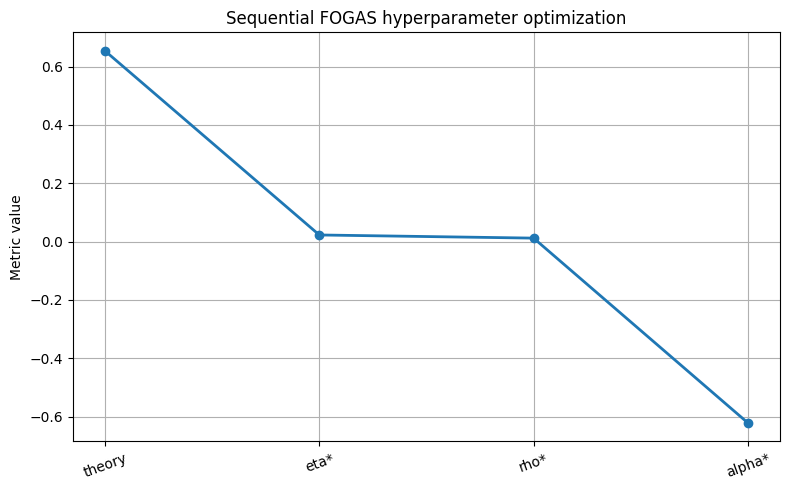

In [71]:
summary = optimizer.optimize_fogas_hyperparameters(
    search_method="random",
    coarse_points=20,
    print_main=True, 
    num_runs=2,
    order=("eta", "rho", "alpha")
)

alpha_star = summary["alpha"]
rho_star = summary["rho"]
eta_star = summary["eta"]

In [72]:
solver.run(alpha=alpha_star, eta=eta_star, rho=rho_star, tqdm_print=True)
evaluator.compare_value_functions()
evaluator.print_policy()

FOGAS Oracle:   0%|          | 0/600 [00:00<?, ?it/s]

FOGAS Oracle: 100%|██████████| 600/600 [00:00<00:00, 7344.32it/s]


========== VALUE FUNCTION COMPARISON ==========

State-wise V comparison:
State 0: V*(x) =  6.217100 | V^π(x) =  6.217100 | Δ =  8.881784e-16
State 1: V*(x) =  5.495390 | V^π(x) =  5.495390 | Δ = -1.742650e-10
State 2: V*(x) =  4.845851 | V^π(x) =  4.845849 | Δ = -2.147153e-06
State 3: V*(x) =  7.019000 | V^π(x) =  7.019000 | Δ =  0.000000e+00
State 4: V*(x) =  7.910000 | V^π(x) =  7.910000 | Δ =  0.000000e+00
State 5: V*(x) = -50.000000 | V^π(x) = -50.000000 | Δ =  0.000000e+00
State 6: V*(x) =  7.910000 | V^π(x) =  7.910000 | Δ =  0.000000e+00
State 7: V*(x) =  8.900000 | V^π(x) =  8.900000 | Δ =  0.000000e+00
State 8: V*(x) =  10.000000 | V^π(x) =  10.000000 | Δ =  0.000000e+00

Action-value Q comparison:
(x=0, a=0): Q*(x,a) =  5.495390 | Q^π(x,a) =  5.495390 | Δ =  8.881784e-16
(x=0, a=1): Q*(x,a) =  6.217100 | Q^π(x,a) =  6.217100 | Δ =  0.000000e+00
(x=0, a=2): Q*(x,a) =  5.495390 | Q^π(x,a) =  5.495390 | Δ =  8.881784e-16
(x=0, a=3): Q*(x,a) =  4.845851 | Q^π(x,a) =  4.845851 |

### Dataset Collection

In [73]:
collector = EnvDataCollector(mdp=mdp, env_name="3grid_wall", max_steps=100)
collector.collect_dataset(n_steps=1000, save_path=str(DATASET_PATH), verbose=True)

✅ Dataset saved to: /home/mauro/Desktop/EMAI/Ljubljana/Thesis/Code/datasets/3grid_wall.csv
   Total transitions: 1000


,episode,step,state,action,reward,next_state
0,0,0,0,0,-0.1,0
1,0,1,0,0,-0.1,0
2,0,2,0,3,-0.1,1
3,0,3,1,2,-0.1,0
4,0,4,0,2,-0.1,0
...,...,...,...,...,...,...
995,49,10,2,3,-0.1,2
996,49,11,2,3,-0.1,2
997,49,12,2,2,-0.1,1
998,49,13,1,3,-0.1,2


### Empirical

In [74]:
solver_e = FOGASSolverVectorized(
    mdp=mdp, 
    print_params=True, 
    csv_path=str(DATASET_PATH
), T=1000)
evaluator_e = FOGASEvaluator(solver_e)
optimizer_e = FOGASHyperOptimizer(solver=solver_e,metric_callable=evaluator_e.get_metric("reward"), seed=seed)


================ FOGAS PARAMETER SUMMARY ================

Basic Information
-----------------
Dataset size n:           1000
Feature norm bound R:     1.0000
Num states N:             9
Num actions A:            4
Feature dim d:            36
Discount γ:               0.9
Confidence δ:             0.05

Theoretical Quantities
----------------------
T_min (theoretical):      925.5128526390366
T (iterations):                1000   (overridden → 1000)

FOGAS Hyperparameters
---------------------
alpha:                        0.000878
rho:                            596.628481
eta:                            0.000017
D_theta:                    18.973666
beta (ridge):             0.000028
D_pi (derived):           16.651092




Trying same optimal hyperparameters found for the oracle.

In [75]:
solver_e.run(alpha=alpha_star, eta=eta_star, rho=rho_star, tqdm_print=True, print_policies=True)
evaluator_e.compare_value_functions()
evaluator_e.compare_final_rewards()


Iteration 1
  State 0: π(a=0|s=0) = 0.25  π(a=1|s=0) = 0.25  π(a=2|s=0) = 0.25  π(a=3|s=0) = 0.25  --> best action: 0
  State 1: π(a=0|s=1) = 0.25  π(a=1|s=1) = 0.25  π(a=2|s=1) = 0.25  π(a=3|s=1) = 0.25  --> best action: 0
  State 2: π(a=0|s=2) = 0.25  π(a=1|s=2) = 0.25  π(a=2|s=2) = 0.25  π(a=3|s=2) = 0.25  --> best action: 0
  State 3: π(a=0|s=3) = 0.25  π(a=1|s=3) = 0.25  π(a=2|s=3) = 0.25  π(a=3|s=3) = 0.25  --> best action: 0
  State 4: π(a=0|s=4) = 0.25  π(a=1|s=4) = 0.25  π(a=2|s=4) = 0.25  π(a=3|s=4) = 0.25  --> best action: 0
  State 5: π(a=0|s=5) = 0.25  π(a=1|s=5) = 0.25  π(a=2|s=5) = 0.25  π(a=3|s=5) = 0.25  --> best action: 0
  State 6: π(a=0|s=6) = 0.25  π(a=1|s=6) = 0.25  π(a=2|s=6) = 0.25  π(a=3|s=6) = 0.25  --> best action: 0
  State 7: π(a=0|s=7) = 0.25  π(a=1|s=7) = 0.25  π(a=2|s=7) = 0.25  π(a=3|s=7) = 0.25  --> best action: 0
  State 8: π(a=0|s=8) = 0.25  π(a=1|s=8) = 0.25  π(a=2|s=8) = 0.25  π(a=3|s=8) = 0.25  --> best action: 0


Iteration 101
  State 0: π(a=0|

Try again first eta, end alpha


=== FOGAS Hyperparameter Optimization ===
[Initial] metric = 1.1947
Order: ('alpha', 'rho', 'eta')

Optimizing alpha
[After alpha*] alpha=4.9337e+00, rho=3.0000e+00, eta=1.0000e-02 | metric = -0.6217

Optimizing rho
[After rho*] alpha=4.9337e+00, rho=1.0000e-02, eta=1.0000e-02 | metric = -0.6217

Optimizing eta
[After eta*] alpha=4.9337e+00, rho=1.0000e-02, eta=1.0000e-02 | metric = -0.6217


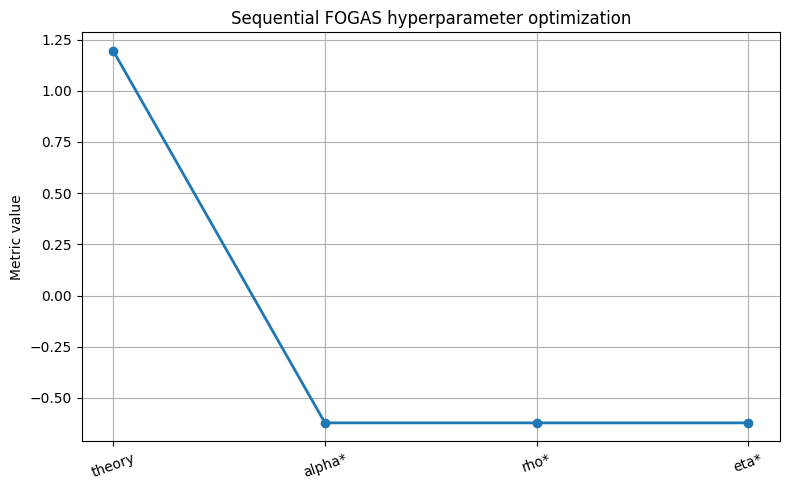

In [76]:
summary_e = optimizer_e.optimize_fogas_hyperparameters(
    search_method="random",
    coarse_points=15,
    print_main=True, 
    num_runs=1,
    random_candidates=30,
    order=("alpha", "rho", "eta"),
    bounds_overrides={"alpha" : (1e-2, 5.0), "rho" : (1e-2, 3.0), "eta" : (1e-2, 3.0)}
)

alpha_star_e = summary_e["alpha"]
rho_star_e = summary_e["rho"]
eta_star_e = summary_e["eta"]

In [77]:
solver_e.run(alpha=alpha_star_e, eta=eta_star_e, rho=rho_star_e, tqdm_print=True, T=1000)
evaluator_e.compare_value_functions()
evaluator_e.compare_final_rewards()
evaluator_e.print_policy()

FOGAS:   0%|          | 0/1000 [00:00<?, ?it/s]

FOGAS: 100%|██████████| 1000/1000 [00:00<00:00, 2603.47it/s]


========== VALUE FUNCTION COMPARISON ==========

State-wise V comparison:
State 0: V*(x) =  6.217100 | V^π(x) =  6.217100 | Δ =  0.000000e+00
State 1: V*(x) =  5.495390 | V^π(x) = -40.690000 | Δ = -4.618539e+01
State 2: V*(x) =  4.845851 | V^π(x) = -45.100000 | Δ = -4.994585e+01
State 3: V*(x) =  7.019000 | V^π(x) =  7.019000 | Δ =  0.000000e+00
State 4: V*(x) =  7.910000 | V^π(x) = -16.923475 | Δ = -2.483348e+01
State 5: V*(x) = -50.000000 | V^π(x) = -50.000000 | Δ =  0.000000e+00
State 6: V*(x) =  7.910000 | V^π(x) =  7.910000 | Δ =  0.000000e+00
State 7: V*(x) =  8.900000 | V^π(x) =  8.900000 | Δ =  0.000000e+00
State 8: V*(x) =  10.000000 | V^π(x) =  10.000000 | Δ =  0.000000e+00

Action-value Q comparison:
(x=0, a=0): Q*(x,a) =  5.495390 | Q^π(x,a) =  5.495390 | Δ =  0.000000e+00
(x=0, a=1): Q*(x,a) =  6.217100 | Q^π(x,a) =  6.217100 | Δ =  0.000000e+00
(x=0, a=2): Q*(x,a) =  5.495390 | Q^π(x,a) =  5.495390 | Δ =  0.000000e+00
(x=0, a=3): Q*(x,a) =  4.845851 | Q^π(x,a) = -36.7210

It converged because the reward is almost the same but 

# State-aggregation features

## Definition

## Testing

In [78]:
# -----------------------------
# Problem definition
# -----------------------------
states = np.arange(9)
actions = np.arange(4)
N = len(states)
A = len(actions)
gamma = 0.9

x_0 = 0

goal = 8   # absorbing terminal state
pit  = 5   # absorbing terminal state
wall = 4   # wall cell

step_cost   = -0.01
goal_reward = 1.0
pit_reward  = -1.0

# -----------------------------
# Helpers: state index <-> (row, col)
# -----------------------------
def to_rc(s):  return divmod(int(s), 3)
def to_s(r,c): return int(r)*3 + int(c)

# -----------------------------
# Deterministic dynamics
# -----------------------------
def next_state(s, a):
    s = int(s); a = int(a)

    # absorbing terminals
    if s == goal or s == pit:
        return s

    r, c = to_rc(s)

    if a == 0:      # Up
        r2, c2 = max(0, r-1), c
    elif a == 1:    # Down
        r2, c2 = min(2, r+1), c
    elif a == 2:    # Left
        r2, c2 = r, max(0, c-1)
    elif a == 3:    # Right
        r2, c2 = r, min(2, c+1)
    else:
        raise ValueError("Invalid action")

    sp = to_s(r2, c2)

    # wall blocks transition
    if sp == wall:
        return s

    return sp

# -----------------------------
# Build explicit transition matrix P: shape (N*A, N)
# Row corresponds to (x,a) in row-major order: idx = x*A + a
# -----------------------------
P = np.zeros((N * A, N))
for x in states:
    for a in actions:
        idx = int(x) * A + int(a)
        xp = next_state(x, a)
        P[idx, xp] = 1.0

# -----------------------------
# action features: [1, dr, dc] in R^3
# state features: row_onehot ⊗ col_onehot in R^9 (exact state one-hot)
# phi(x,a) = kron(phi_action(a), phi_state(x)) in R^(3*9)=R^27
# -----------------------------
d_state  = 9
d_action = 3
d_feat   = d_state * d_action  # 27

def phi_state(x):
    r, c = to_rc(x)
    row = np.zeros(3); row[r] = 1.0
    col = np.zeros(3); col[c] = 1.0
    return np.kron(row, col)  # R^9

def phi_action(a):
    a = int(a)
    if a == 0:   dr, dc = -1.0,  0.0  # Up
    elif a == 1: dr, dc =  1.0,  0.0  # Down
    elif a == 2: dr, dc =  0.0, -1.0  # Left
    elif a == 3: dr, dc =  0.0,  1.0  # Right
    else:
        raise ValueError("Invalid action")
    return np.array([1.0, dr, dc])  # R^3

def phi(x, a):
    return np.kron(phi_action(a), phi_state(x))  # R^27

# -----------------------------
# Exact omega for state-only reward:
# r(x,a) = r_state(x) for all actions
# Put r_state into the "bias block" omega[0:9], rest zeros.
# -----------------------------
r_state = np.full(N, step_cost)
r_state[goal] = goal_reward
r_state[pit]  = pit_reward

omega = np.zeros(d_feat)
omega[:d_state] = r_state  # exact

mdp = PolicySolver(states=states, actions=actions, phi=phi, omega=omega, gamma=gamma, x0=x_0, P=P)

### Oracle

In [79]:
solver = FOGASOracleSolverVectorized(
    mdp=mdp, 
    cov_matrix="identity", 
    print_params=True, 
    T=1500
)
evaluator = FOGASEvaluator(solver)
optimizer = FOGASHyperOptimizer(solver=solver,metric_callable=evaluator.get_metric("reward"), seed=seed)


================ FOGAS PARAMETER SUMMARY ================

Basic Information
-----------------
Dataset size n:           10000000.0
Feature norm bound R:     1.4142
Num states N:             9
Num actions A:            4
Feature dim d:            27
Discount γ:               0.9
Confidence δ:             0.05

Theoretical Quantities
----------------------
T_min (theoretical):      18510257.052780736
T (iterations):                1500   (overridden → 1500)

FOGAS Hyperparameters
---------------------
alpha:                        0.000585
rho:                            4.559519
eta:                            0.000013
D_theta:                    16.431677
beta (ridge):             0.000049
D_pi (derived):           14.420269





=== FOGAS Hyperparameter Optimization ===
[Initial] metric = 0.0647
Order: ('alpha', 'rho', 'eta')

Optimizing alpha
[After alpha*] alpha=4.1345e+00, rho=5.0000e+00, eta=1.3013e-05 | metric = -0.6507

Optimizing rho
[After rho*] alpha=4.1345e+00, rho=4.2655e+00, eta=1.3013e-05 | metric = -0.6515

Optimizing eta
[After eta*] alpha=4.1345e+00, rho=4.2655e+00, eta=1.6563e-02 | metric = -0.6527


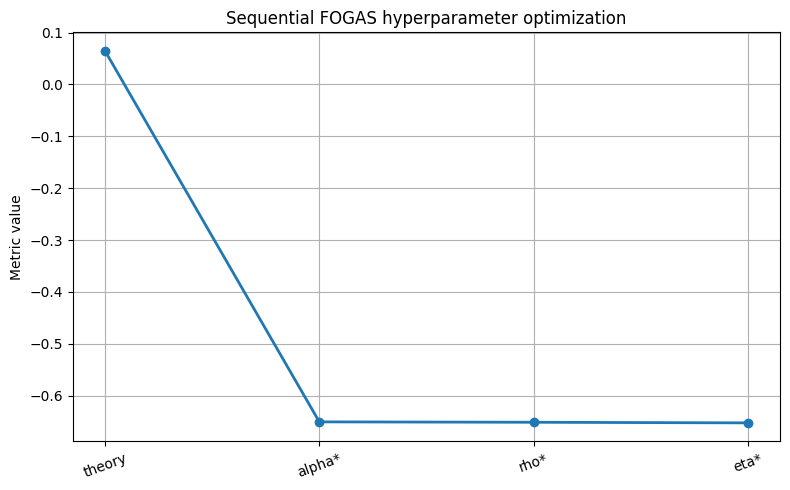

In [80]:
summary = optimizer.optimize_fogas_hyperparameters(
    search_method="random",
    coarse_points=20,
    print_main=True, 
    num_runs=2,
    order=("alpha", "rho", "eta")
)

alpha_star = summary["alpha"]
rho_star = summary["rho"]
eta_star = summary["eta"]

In [81]:
solver.run(alpha=alpha_star, eta=eta_star, rho=rho_star, tqdm_print=True)
evaluator.compare_value_functions()

FOGAS Oracle:   0%|          | 0/1500 [00:00<?, ?it/s]

FOGAS Oracle: 100%|██████████| 1500/1500 [00:00<00:00, 7593.05it/s]


========== VALUE FUNCTION COMPARISON ==========

State-wise V comparison:
State 0: V*(x) =  6.526610 | V^π(x) =  6.526610 | Δ = -8.276947e-09
State 1: V*(x) =  5.863949 | V^π(x) = -8.114815 | Δ = -1.397876e+01
State 2: V*(x) =  5.267554 | V^π(x) = -9.005350 | Δ = -1.427290e+01
State 3: V*(x) =  7.262900 | V^π(x) =  7.262900 | Δ = -9.149043e-09
State 4: V*(x) =  8.081000 | V^π(x) =  8.081000 | Δ = -2.028674e-09
State 5: V*(x) = -10.000000 | V^π(x) = -10.000000 | Δ =  0.000000e+00
State 6: V*(x) =  8.081000 | V^π(x) =  8.081000 | Δ = -1.016561e-08
State 7: V*(x) =  8.990000 | V^π(x) =  8.990000 | Δ = -2.254081e-09
State 8: V*(x) =  10.000000 | V^π(x) =  10.000000 | Δ =  0.000000e+00

Action-value Q comparison:
(x=0, a=0): Q*(x,a) =  5.863949 | Q^π(x,a) =  5.863949 | Δ = -7.449253e-09
(x=0, a=1): Q*(x,a) =  6.526610 | Q^π(x,a) =  6.526610 | Δ = -8.234139e-09
(x=0, a=2): Q*(x,a) =  5.863949 | Q^π(x,a) =  5.863949 | Δ = -7.449253e-09
(x=0, a=3): Q*(x,a) =  5.267554 | Q^π(x,a) = -7.313334 |

In [82]:
evaluator.print_policy()

  State 0: π(a=0|s=0) = 0.00  π(a=1|s=0) = 1.00  π(a=2|s=0) = 0.00  π(a=3|s=0) = 0.00  --> best action: 1
  State 1: π(a=0|s=1) = 0.00  π(a=1|s=1) = 0.00  π(a=2|s=1) = 0.00  π(a=3|s=1) = 1.00  --> best action: 3
  State 2: π(a=0|s=2) = 0.00  π(a=1|s=2) = 0.99  π(a=2|s=2) = 0.00  π(a=3|s=2) = 0.01  --> best action: 1
  State 3: π(a=0|s=3) = 0.00  π(a=1|s=3) = 1.00  π(a=2|s=3) = 0.00  π(a=3|s=3) = 0.00  --> best action: 1
  State 4: π(a=0|s=4) = 0.00  π(a=1|s=4) = 1.00  π(a=2|s=4) = 0.00  π(a=3|s=4) = 0.00  --> best action: 1
  State 5: π(a=0|s=5) = 0.25  π(a=1|s=5) = 0.25  π(a=2|s=5) = 0.25  π(a=3|s=5) = 0.25  --> best action: 0
  State 6: π(a=0|s=6) = 0.00  π(a=1|s=6) = 0.00  π(a=2|s=6) = 0.00  π(a=3|s=6) = 1.00  --> best action: 3
  State 7: π(a=0|s=7) = 0.00  π(a=1|s=7) = 0.00  π(a=2|s=7) = 0.00  π(a=3|s=7) = 1.00  --> best action: 3
  State 8: π(a=0|s=8) = 0.25  π(a=1|s=8) = 0.25  π(a=2|s=8) = 0.25  π(a=3|s=8) = 0.25  --> best action: 0



### Empirical

In [83]:
solver_e = FOGASSolverVectorized(
    mdp=mdp, 
    print_params=True, 
    csv_path=str(DATASET_PATH
), T=1500)
evaluator_e = FOGASEvaluator(solver_e)
optimizer_e = FOGASHyperOptimizer(solver=solver_e,metric_callable=evaluator_e.get_metric("reward"), seed=seed)


================ FOGAS PARAMETER SUMMARY ================

Basic Information
-----------------
Dataset size n:           1000
Feature norm bound R:     1.4142
Num states N:             9
Num actions A:            4
Feature dim d:            27
Discount γ:               0.9
Confidence δ:             0.05

Theoretical Quantities
----------------------
T_min (theoretical):      1851.025705278074
T (iterations):                1500   (overridden → 1500)

FOGAS Hyperparameters
---------------------
alpha:                        0.000585
rho:                            455.951925
eta:                            0.000013
D_theta:                    16.431677
beta (ridge):             0.000049
D_pi (derived):           14.420269




In [84]:
solver_e.run(alpha=alpha_star, eta=eta_star, rho=rho_star, tqdm_print=True)
evaluator_e.compare_value_functions()
evaluator_e.compare_final_rewards()

FOGAS:   0%|          | 0/1500 [00:00<?, ?it/s]

FOGAS: 100%|██████████| 1500/1500 [00:00<00:00, 2620.02it/s]


========== VALUE FUNCTION COMPARISON ==========

State-wise V comparison:
State 0: V*(x) =  6.526610 | V^π(x) =  6.526608 | Δ = -1.714968e-06
State 1: V*(x) =  5.863949 | V^π(x) = -8.083519 | Δ = -1.394747e+01
State 2: V*(x) =  5.267554 | V^π(x) = -8.970577 | Δ = -1.423813e+01
State 3: V*(x) =  7.262900 | V^π(x) =  7.262898 | Δ = -1.644371e-06
State 4: V*(x) =  8.081000 | V^π(x) = -0.421890 | Δ = -8.502890e+00
State 5: V*(x) = -10.000000 | V^π(x) = -10.000000 | Δ =  0.000000e+00
State 6: V*(x) =  8.081000 | V^π(x) =  8.080998 | Δ = -1.827079e-06
State 7: V*(x) =  8.990000 | V^π(x) =  8.990000 | Δ =  0.000000e+00
State 8: V*(x) =  10.000000 | V^π(x) =  10.000000 | Δ =  0.000000e+00

Action-value Q comparison:
(x=0, a=0): Q*(x,a) =  5.863949 | Q^π(x,a) =  5.863947 | Δ = -1.543471e-06
(x=0, a=1): Q*(x,a) =  6.526610 | Q^π(x,a) =  6.526609 | Δ = -1.479934e-06
(x=0, a=2): Q*(x,a) =  5.863949 | Q^π(x,a) =  5.863947 | Δ = -1.543471e-06
(x=0, a=3): Q*(x,a) =  5.267554 | Q^π(x,a) = -7.285167 |


=== FOGAS Hyperparameter Optimization ===
[Initial] metric = -0.0118
Order: ('alpha', 'rho', 'eta')

Optimizing alpha
[After alpha*] alpha=4.4392e+00, rho=3.0000e+00, eta=1.0000e-02 | metric = -0.6527

Optimizing rho
[After rho*] alpha=4.4392e+00, rho=3.0000e+00, eta=1.0000e-02 | metric = -0.6527

Optimizing eta
[After eta*] alpha=4.4392e+00, rho=3.0000e+00, eta=1.0000e-02 | metric = -0.6527


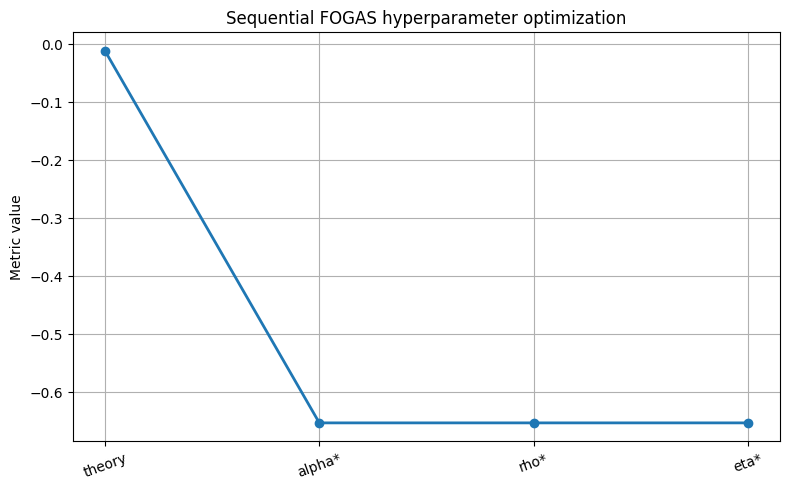

In [86]:
summary_e = optimizer_e.optimize_fogas_hyperparameters(
    search_method="random",
    coarse_points=15,
    print_main=True, 
    num_runs=1,
    random_candidates=30,
    order=("alpha", "rho", "eta"),
    bounds_overrides={"alpha" : (1e-2, 5.0), "rho" : (1e-2, 3.0), "eta" : (1e-2, 3.0)}
)

alpha_star_e = summary_e["alpha"]
rho_star_e = summary_e["rho"]
eta_star_e = summary_e["eta"]

In [89]:
solver_e.run(alpha=alpha_star, eta=eta_star, rho=rho_star, tqdm_print=True)
evaluator_e.compare_value_functions()
evaluator_e.compare_final_rewards()

FOGAS:   0%|          | 0/1500 [00:00<?, ?it/s]

FOGAS: 100%|██████████| 1500/1500 [00:00<00:00, 3011.51it/s]


========== VALUE FUNCTION COMPARISON ==========

State-wise V comparison:
State 0: V*(x) =  6.526610 | V^π(x) =  6.526608 | Δ = -1.714968e-06
State 1: V*(x) =  5.863949 | V^π(x) = -8.083519 | Δ = -1.394747e+01
State 2: V*(x) =  5.267554 | V^π(x) = -8.970577 | Δ = -1.423813e+01
State 3: V*(x) =  7.262900 | V^π(x) =  7.262898 | Δ = -1.644371e-06
State 4: V*(x) =  8.081000 | V^π(x) = -0.421890 | Δ = -8.502890e+00
State 5: V*(x) = -10.000000 | V^π(x) = -10.000000 | Δ =  0.000000e+00
State 6: V*(x) =  8.081000 | V^π(x) =  8.080998 | Δ = -1.827079e-06
State 7: V*(x) =  8.990000 | V^π(x) =  8.990000 | Δ =  0.000000e+00
State 8: V*(x) =  10.000000 | V^π(x) =  10.000000 | Δ =  0.000000e+00

Action-value Q comparison:
(x=0, a=0): Q*(x,a) =  5.863949 | Q^π(x,a) =  5.863947 | Δ = -1.543471e-06
(x=0, a=1): Q*(x,a) =  6.526610 | Q^π(x,a) =  6.526609 | Δ = -1.479934e-06
(x=0, a=2): Q*(x,a) =  5.863949 | Q^π(x,a) =  5.863947 | Δ = -1.543471e-06
(x=0, a=3): Q*(x,a) =  5.267554 | Q^π(x,a) = -7.285167 |

In [ ]:
solver_e.run(alpha=alpha_star, eta=eta_star, rho=rho_star, tqdm_print=True)
evaluator_e.compare_value_functions()
evaluator_e.compare_final_rewards()

FOGAS:   0%|          | 0/1500 [00:00<?, ?it/s]

FOGAS: 100%|██████████| 1500/1500 [00:00<00:00, 3011.51it/s]


========== VALUE FUNCTION COMPARISON ==========

State-wise V comparison:
State 0: V*(x) =  6.526610 | V^π(x) =  6.526608 | Δ = -1.714968e-06
State 1: V*(x) =  5.863949 | V^π(x) = -8.083519 | Δ = -1.394747e+01
State 2: V*(x) =  5.267554 | V^π(x) = -8.970577 | Δ = -1.423813e+01
State 3: V*(x) =  7.262900 | V^π(x) =  7.262898 | Δ = -1.644371e-06
State 4: V*(x) =  8.081000 | V^π(x) = -0.421890 | Δ = -8.502890e+00
State 5: V*(x) = -10.000000 | V^π(x) = -10.000000 | Δ =  0.000000e+00
State 6: V*(x) =  8.081000 | V^π(x) =  8.080998 | Δ = -1.827079e-06
State 7: V*(x) =  8.990000 | V^π(x) =  8.990000 | Δ =  0.000000e+00
State 8: V*(x) =  10.000000 | V^π(x) =  10.000000 | Δ =  0.000000e+00

Action-value Q comparison:
(x=0, a=0): Q*(x,a) =  5.863949 | Q^π(x,a) =  5.863947 | Δ = -1.543471e-06
(x=0, a=1): Q*(x,a) =  6.526610 | Q^π(x,a) =  6.526609 | Δ = -1.479934e-06
(x=0, a=2): Q*(x,a) =  5.863949 | Q^π(x,a) =  5.863947 | Δ = -1.543471e-06
(x=0, a=3): Q*(x,a) =  5.267554 | Q^π(x,a) = -7.285167 |